In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread
from os import listdir
from keras.preprocessing.image import load_img, img_to_array
from numpy import asarray, savez_compressed, load
from collections import Counter
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, shuffle
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from keras.utils import to_categorical
from keras.applications import resnet50  
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.models import Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score


Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [3]:
#Function to load saved satellite imagery data
def load_saved_dataset(file):
    data = load(file)
    X, y = data['arr_0'], data['arr_1']
    trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.20, random_state=1)
    print(trainX.shape, trainY.shape, testX.shape, testY.shape)
    return trainX, trainY, testX, testY

#function to visualize model accuracy and model loss curves
def visualize(model_history):
    # summarize history for accuracy
    plt.plot(model_history.history['acc'])
    plt.plot(model_history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

#function to evaluate model    
def eval(testY, predY):
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(testY, predY)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(testY, predY, average='macro')
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(testY, predY, average='macro')
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(testY, predY, average='macro')
    print('F1 score: %f' % f1)
    cm = confusion_matrix(testY, predY)
    print('Confusion Matrix:\n', cm)

In [ ]:
#class weight approach
#load data
trainX, trainY, testX, testY = load_saved_dataset('total_acc.npz')

In [4]:
#Determine class weights
class_weights = class_weight.compute_class_weight('balanced', np.unique(trainY), trainY)
print('Class Weights: ', class_weights)

Class Weights:  [  0.26331869   7.02534912  19.84691252 104.24099099]


In [ ]:
print(Counter(trainY))
#prepare data for training
trainY = to_categorical(trainY)
testY = to_categorical(testY)
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

In [ ]:
#train class weight approach model
base_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape= (128,128,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)
model_cw = Model(inputs=base_model.input, outputs=predictions)

model_cw.compile(optimizer=Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics=['acc'])

history = model_cw.fit(trainX, trainY, class_weight=class_weights, validation_data=(testX, testY), epochs= 50, batch_size = 256)


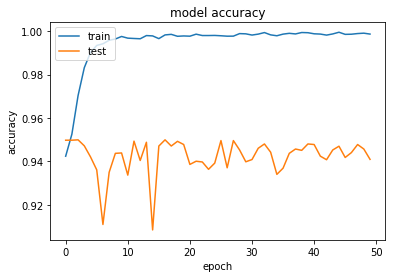

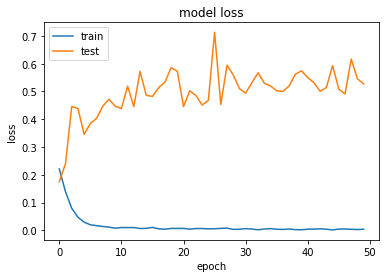

In [9]:
visualize(history)

In [13]:
#model predictions
predictions = model_cw.predict(testX)
predY = np.argmax(predictions, axis=1)
testY = np.argmax(testY, axis=1)

In [15]:
#Results - Class weight approach
eval(testY, predY)

Accuracy: 0.940973
Precision: 0.360605
Recall: 0.309244
F1 score: 0.320438
Confusion Matrix:
 [[10806   175     8     6]
 [  314    78     9     1]
 [   96    46     3     4]
 [   15     8     1     1]]


In [40]:
#Undersampling approach
trainX, trainY, testX, testY = load_saved_dataset('total_acc.npz')

(46283, 128, 128, 3) (46283,) (11571, 128, 128, 3) (11571,)


In [41]:
#Determine number of instances in minority class
Counter(trainY)
m=111

In [42]:
#Undersample classes
trainX = trainX.reshape(trainX.shape[0], -1)
rus = RandomUnderSampler('auto')
trainX, trainY = rus.fit_sample(trainX, trainY)
print(Counter(trainY))

Counter({0: 111, 1: 111, 2: 111, 3: 111})


In [47]:
#prepare data for training
trainX = trainX.reshape(trainX.shape[0], 128, 128, 3)
trainY = to_categorical(trainY)
testY = to_categorical(testY)
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(444, 128, 128, 3) (444, 4) (11571, 128, 128, 3) (11571, 4)


In [48]:
#train Undersampling approach model
base_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape= (128,128,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)
model_us = Model(inputs=base_model.input, outputs=predictions)

model_us.compile(optimizer=Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics=['acc'])

history = model_us.fit(trainX, trainY, validation_data=(testX, testY), epochs= 50, batch_size = 256)

W0804 18:18:38.625591 140247575262976 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 444 samples, validate on 11571 samples
Epoch 1/50
444/444 [==============================] - 46s 103ms/step - loss: 1.7886 - acc: 0.2860 - val_loss: 1.4752 - val_acc: 0.3059
Epoch 2/50
444/444 [==============================] - 18s 42ms/step - loss: 1.0158 - acc: 0.6036 - val_loss: 1.3909 - val_acc: 0.3898
Epoch 3/50
444/444 [==============================] - 18s 42ms/step - loss: 0.5714 - acc: 0.8288 - val_loss: 1.2879 - val_acc: 0.4797
Epoch 4/50
444/444 [==============================] - 19s 42ms/step - loss: 0.3566 - acc: 0.9122 - val_loss: 1.1923 - val_acc: 0.5369
Epoch 5/50
444/444 [==============================] - 19s 43ms/step - loss: 0.2651 - acc: 0.9369 - val_loss: 1.1171 - val_acc: 0.5712
Epoch 6/50
444/444 [==============================] - 19s 43ms/step - loss: 0.1637 - acc: 0.9842 - val_loss: 1.0648 - val_acc: 0.5936
Epoch 7/50
444/444 [==============================] - 19s 42ms/step - loss: 0.1164 - acc: 0.9955 - val_loss: 1.0329 - val_acc: 0.6043
Epoch 8/50
44

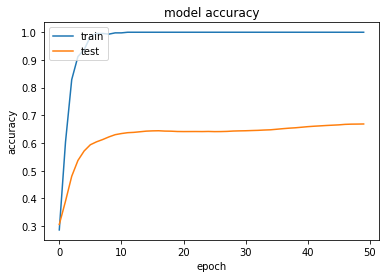

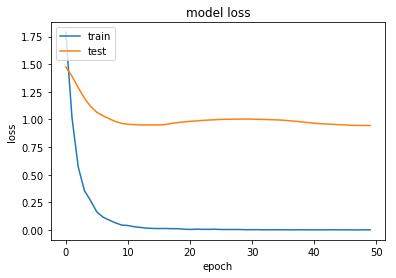

In [49]:
visualize(history)

In [50]:
#model predictions
predictions = model_us.predict(testX)
predY = np.argmax(predictions, axis=1)
testY = np.argmax(testY, axis=1)

In [51]:
#Results - Undersampling 
eval(testY, predY)

Accuracy: 0.668654
Precision: 0.275094
Recall: 0.448974
F1 score: 0.252945
Confusion Matrix:
 [[7568 1695 1079  653]
 [  94   93  137   78]
 [  22   23   65   39]
 [   2    2   10   11]]


In [ ]:
#SMOTE approach
trainX, trainY, testX, testY = load_saved_dataset('total_acc.npz')

In [ ]:
#implement SMOTE
trainX = trainX.reshape(trainX.shape[0], -1)
sm = SMOTE('auto')
X_sm, Y_sm = sm.fit_sample(trainX, trainY)
print(X_sm.shape, Y_sm.shape)

In [6]:
#Balanced classes
Counter(Y_sm)

Counter({0: 43942, 1: 43942, 2: 43942, 3: 43942})

In [ ]:
#prepare data for training
X_sm = X_sm.reshape(X_sm.shape[0], 128, 128, 3)
Y_sm = to_categorical(Y_sm)
testY = to_categorical(testY)
print(X_sm.shape, Y_sm.shape, testX.shape, testY.shape)

In [ ]:
#train SMOTE approach model
base_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape= (128,128,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)
model_sm = Model(inputs=base_model.input, outputs=predictions)

model_sm.compile(optimizer=Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics=['acc'])

history = model_sm.fit(X_sm, Y_sm, validation_data=(testX, testY), epochs= 50, batch_size = 256)

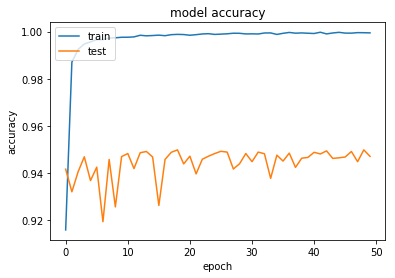

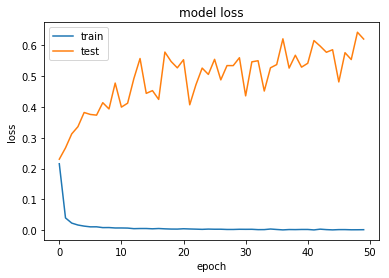

In [12]:
visualize(history)

In [ ]:
#model predictions
predictions = model_sm.predict(testX)
predY = np.argmax(predictions, axis=1)
testY = np.argmax(testY, axis=1)

In [43]:
#Results - SMOTE 
eval(testY, predY)

Accuracy: 0.947023
Precision: 0.312159
Recall: 0.261599
F1 score: 0.265032
Confusion Matrix:
 [[10939    54     2     0]
 [  374    18     8     2]
 [  137    11     1     0]
 [   22     2     1     0]]


In [ ]:
#SMOTE with Undersampling approach
trainX, trainY, testX, testY = load_saved_dataset('total_acc.npz')

In [4]:
print(Counter(trainY), Counter(testY))

Counter({0: 43942, 1: 1647, 2: 583, 3: 111}) Counter({0: 10995, 1: 402, 2: 149, 3: 25})


In [ ]:
#find average number of instances
m = round((sum(Counter(trainY).values())/4))
#implement SMOTE on minority classes
trainX = trainX.reshape(trainX.shape[0], -1)
sm = SMOTE({1:m, 2:m, 3:m})
X_sm, Y_sm = sm.fit_sample(trainX, trainY)
print(X_sm.shape, Y_sm.shape)

In [ ]:
Counter(Y_sm)

In [ ]:
#split out majority set from dataset
ds_maj = []
X_tmp = []
Y_tmp = []
for i in range(len(X_sm)):
    target = Y_sm[i]
    var = X_sm[i]
    if target == 0:
        ds_maj.append(var)
    if target == 1:
        X_tmp.append(var)
        Y_tmp.append(1)
    if target == 2:
        X_tmp.append(var)
        Y_tmp.append(2)
    if target == 3:
        X_tmp.append(var)
        Y_tmp.append(3)

X_tmp = np.asarray(X_tmp)
Y_tmp = np.asarray(Y_tmp)
ds_maj = np.asarray(ds_maj)
print(X_tmp.shape, Y_tmp.shape, ds_maj.shape)

In [ ]:
#undersample majority set to m number of instances
ds_maj = shuffle(ds_maj, n_samples=m, random_state=1)
#generate target set of 0's for undersampled majority set
ds_maj_y = np.repeat(0, len(ds_maj))

In [ ]:
#combine datasets
X1_tmp = np.concatenate([X_tmp, ds_maj])
Y1_tmp = np.concatenate([Y_tmp, ds_maj_y])
print(X1_tmp.shape, Y1_tmp.shape)
Counter(Y1_tmp)

In [ ]:
#shuffle combined dataset
X_sm, Y_sm = shuffle(X1_tmp, Y1_tmp, random_state=1)
#prepare data for training
X_sm = X_sm.reshape(X_sm.shape[0], 128, 128, 3)
Y_sm = to_categorical(Y_sm)
testY = to_categorical(testY)
print(X_sm.shape, Y_sm.shape, testX.shape, testY.shape)

In [ ]:
#train SMOTE with undersampling approach model
base_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape= (128,128,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)
model_smus = Model(inputs=base_model.input, outputs=predictions)

model_smus.compile(optimizer=Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics=['acc'])

history = model_smus.fit(X_sm, Y_sm, validation_data=(testX, testY), epochs= 50, batch_size = 256)


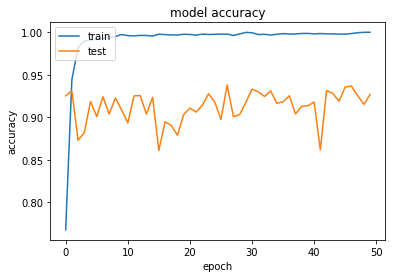

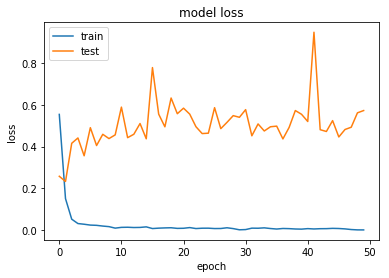

In [28]:
visualize(history)

In [ ]:
#model predictions
predictions = model_smus.predict(testX)
predY = np.argmax(predictions, axis=1)
testY = np.argmax(testY, axis=1)

In [32]:
#Results - SMOTE with Undersampling
eval(testY, predY)

Accuracy: 0.926713
Precision: 0.344613
Recall: 0.350815
F1 score: 0.347137
Confusion Matrix:
 [[10592   322    77     4]
 [  267   104    30     1]
 [   74    47    27     1]
 [   10    11     4     0]]
